In [1]:
import os
import sys
import warnings
import tqdm


import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib.animation as animation

import mplcyberpunk
plt.style.use('cyberpunk')

warnings.filterwarnings('ignore')

In [2]:
class WaveEquation(object):

    def __init__(self,
                 K : float = 1.0,
                 G : float = 0.5,
                 rho : float= 1.0,
                 dmp : float= 0.005,
                 lx : float= 10.0,
                 ly : float = 10.0,
                 nx : float = 200,
                 ny : float = 200,
                 nsteps : float = 2500,
                 cfl : float= 0.5):

        self.K = K
        self.G = G
        self.rho = rho
        self.dmp = dmp
        self.lx = lx
        self.ly = ly
        self.nx = nx
        self.ny = ny
        self.nsteps = nsteps
        self.cfl = cfl


        self.x = np.linspace( -0.5 * self.lx, 0.5 * self.lx, self.nx) 
        self.y = np.linspace( -0.5 * self.ly, 0.5 * self.ly, self.ny) 
        self.x, self.y = np.meshgrid(self.x, self.y, indexing = 'ij')
        
        self.dx = self.lx / (self.nx - 1)
        self.dy = self.ly / (self.ny - 1)
        
        self.dt = self.cfl * min(self.dx, self.dy) / np.sqrt((self.K + 4.0 * self.G / 3.0) / self.rho)
        
        # init
        self.p0 = 0.0
        self.p = self.p0 * np.exp(- self.x**2 - self.y**2)
        
        self.tauxx = np.zeros((self.nx, self.ny))
        self.tauyy = np.zeros((self.nx, self.ny))
        self.tauxy = np.zeros((self.nx - 1, self.ny - 1))
        
        self.vx = np.zeros((self.nx + 1, self.ny))
        self.vy = np.zeros((self.nx, self.ny + 1))
        
        self.ux = np.zeros((self.nx + 1, self.ny))
        self.uy = np.zeros((self.nx, self.ny + 1))
        self.ux[0,:] = 0.1

        self.download_gif = True


    def iter(self):
        self.div_u = np.diff(self.ux, axis=0) / self.dx + np.diff(self.uy, axis=1) / self.dy
        
        self.p = - self.div_u * self.K
        
        self.tauxx = (np.diff(self.ux, axis=0) / self.dx - self.div_u / 3.0) * 2.0 * self.G
        self.tauyy = (np.diff(self.uy, axis=1) / self.dy - self.div_u / 3.0) * 2.0 * self.G
        tauxy = (np.diff(self.ux[1:-1, :], axis=1) / self.dy + np.diff(self.uy[:, 1:-1], axis=0) / self.dx) * self.G
    
        self.dvxdt = (np.diff(-self.p[:, 1:-1] + self.tauxx[:, 1:-1], axis=0) / self.dx +
                 np.diff(self.tauxy, axis=1) / self.dy) / self.rho
        self.dvydt = (np.diff(-self.p[1:-1, :] + self.tauyy[1:-1, :], axis=1) / self.dy +
                 np.diff(self.tauxy, axis=0) / self.dx) / self.rho
        
        self.vx[1:-1, 1:-1] = (1 - self.dmp) * self.vx[1:-1, 1:-1] + self.dvxdt * self.dt
        self.vy[1:-1, 1:-1] = (1 - self.dmp) * self.vy[1:-1, 1:-1] + self.dvydt * self.dt
        self.ux[1:-1, 1:-1] = self.ux[1:-1, 1:-1] + self.vx[1:-1, 1:-1] * self.dt
        self.uy[1:-1, 1:-1] = self.uy[1:-1, 1:-1] + self.vy[1:-1, 1:-1] * self.dt


    def update(self, frame):
        self.iter()
        self.mesh_ux.set_array(self.ux[:-1, :].ravel())
        self.mesh_uy.set_array(self.uy[:, :-1].ravel())
        return self.mesh_ux, self.mesh_uy


    def process(self):
        self.fig, self.axs = plt.subplots(1, 2, figsize=(15, 5))
        self.fig.suptitle("Растяжение вдоль X")
        
        self.mesh_ux = self.axs[0].pcolormesh(self.x, self.y, self.ux[:-1, :] ,shading='auto')
        self.axs[0].set_title("Перемещения по X")
        self.axs[0].set_aspect('equal')
        self.cbar_ux = plt.colorbar(self.mesh_ux, ax=self.axs[0])
        self.cbar_ux.set_label("ux")
        
        
        self.mesh_uy = self.axs[1].pcolormesh(self.x, self.y, self.uy[:, :-1], vmin = -0.006, vmax = 0.006, shading='auto')
        self.axs[1].set_title("Перемещения по Y")
        self.axs[1].set_aspect('equal')
        self.cbar_uy = plt.colorbar(self.mesh_uy, ax=self.axs[1])
        self.cbar_uy.set_label("uy")

        ani = animation.FuncAnimation(self.fig, self.update, frames=self.nsteps, blit=True, interval=10)

        if self.download_gif:
            ani.save("Wave_Equation_Rodionov626.gif", writer = 'pillow')
            

In [3]:
WaveEquation_inctance =WaveEquation()

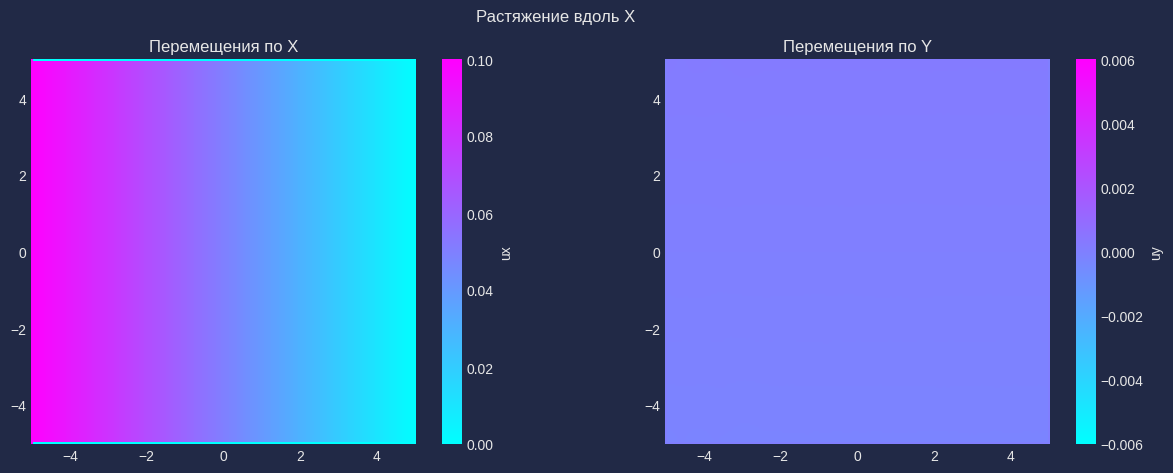

In [4]:
WaveEquation_inctance.process()